In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('./../../datasets/SWEETWATER CREEK.csv',header=0, parse_dates=['time'])

/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2019.10-v5cuhr6keyz5ryxcwvv2jkzfj2gwrj4a/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


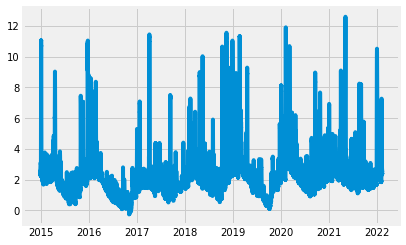

In [4]:
df["time"] = pd.to_datetime(df['time'])
df = df.set_index('time')
plt.plot(df.index,df["height"])

In [5]:
train_set = df[:'2020'].iloc[:,:]
test_set = df['2021':].iloc[:,:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_set)

In [7]:
len(training_set_scaled)

207103

In [8]:
X_train = []
y_train = []
for i in range(100,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-100:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
X_train.shape

(207003, 100, 1)

In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=8)

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [14]:
def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = tf.reduce_sum(tf.abs(tf.subtract(y, y_pred)))
    denominator = tf.add(tf.reduce_sum(tf.abs(y)), K.epsilon())
    wape = tf.scalar_mul(100.0, tf.divide(nominator, denominator))
    return wape

def nse(y, y_pred):
    return (1-(K.sum((y_pred-y)**2)/K.sum((y-K.mean(y))**2)))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

adam = Adam(learning_rate=0.0001)
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=264, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second LSTM layer
regressor.add(LSTM(units=132,return_sequences=True))

# # Third LSTM layer
regressor.add(LSTM(units=64,return_sequences=True))

# # Fouth LSTM layer
regressor.add(LSTM(units=32))


# The Fifth layer
regressor.add(Dense(units=30))

# The Sixth layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer="adam",loss="mean_absolute_error",
                  metrics=[Wape,
                           tf.metrics.MeanAbsoluteError(name="MAE"),
                           tf.metrics.RootMeanSquaredError(name="RMSE"),
                           tf.metrics.MeanAbsolutePercentageError(name="MAPE"),
                           "MSE",
                          ],
                           
                 )


filepath="New Leon\'s/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32,callbacks=callbacks_list)

# Create Model and load weights

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

def create_model():
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=264, return_sequences=True, input_shape=(X_train.shape[1],1)))

    # Second LSTM layer
    regressor.add(LSTM(units=132,return_sequences=True))

    # # Third LSTM layer
    regressor.add(LSTM(units=64,return_sequences=True))

    # # Fouth LSTM layer
    regressor.add(LSTM(units=32))


    # The Fifth layer
    regressor.add(Dense(units=30))

    # The Sixth layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer="adam",loss="mean_absolute_error",
                      metrics=[Wape,
                               tf.metrics.MeanAbsoluteError(name="MAE"),
                               tf.metrics.RootMeanSquaredError(name="RMSE"),
                               tf.metrics.MeanAbsolutePercentageError(name="MAPE"),
                               "MSE",
                              ],

                     )
    return regressor
regressor = create_model()
regressor.load_weights("New Leon's LSTM Sweatwater/weights-improvement-50-0.0010.hdf5")

In [28]:
regressor.save("Sweatwater-LSTM.h5")